In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/KISTI

In [ ]:
# 한글폰트 설치 -> 아래 코드 실행 후, 런타임 재시작해야 함
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 1. EDA

**시작하기 전, 폴더 구조와 이름을 바꾸고 아래 코드들을 실행할 것**
1. dataset_original 이라는 빈 폴더 생성
2. 주어진 데이터셋을 압축 해제한 후 얻은 2개의 폴더(1. 국내어선, 2. 중국어선)을 dataset_original 폴더 밑으로 이동

In [ ]:
from glob import glob

root = "dataset_original"
countries = ["1. 국내어선", "2. 중국어선"]
ship_korea = ["1. 낚시어선", "2. 저인망", "3. 채낚기", "4. 연승", "5. 통발", "6. 안강망"]
ship_china = ["1. 타망", "2. 유망", "3. 범장망", "4. 등광조망"]
statuses = ["이동", "조업", "표류"]

In [ ]:
import pandas as pd

def get_num_of_img(root, countries, ship_korea, ship_china, statuses):

  idx = 0
  output = pd.DataFrame(columns=["country", "ship_type", "status", "count"])

  for country in countries:
    if country == "1. 국내어선":
      for ship in ship_korea:
        for status in statuses:
          # print(root+"/"+country+"/"+ship+"/"+status+":", len(glob(root+"/"+country+"/"+ship+"/"+status+"/*")))
          output.loc[idx] = ["한국", ship[3:], status, len(glob(root+"/"+country+"/"+ship+"/"+status+"/*"))]
          idx += 1

    else:
      for ship in ship_china:
        for status in statuses:
          # print(root+"/"+country+"/"+ship+"/"+status+":", len(glob(root+"/"+country+"/"+ship+"/"+status+"/*")))
          output.loc[idx] = ["중국", ship[3:], status, len(glob(root+"/"+country+"/"+ship+"/"+status+"/*"))]
          idx += 1

  return output

In [ ]:
df_label_distribution = get_num_of_img(root, countries, ship_korea, ship_china, statuses)
df_label_distribution

,country,ship_type,status,count
0,한국,낚시어선,이동,50
1,한국,낚시어선,조업,67
2,한국,낚시어선,표류,10
3,한국,저인망,이동,51
4,한국,저인망,조업,23
5,한국,저인망,표류,7
6,한국,채낚기,이동,16
7,한국,채낚기,조업,5
8,한국,채낚기,표류,40
9,한국,연승,이동,33


In [ ]:
df_label_distribution.to_csv("label_distribution.csv",index=False)

## 1.1. 국적 분포

  country  count
0      중국   1145
1      한국    451


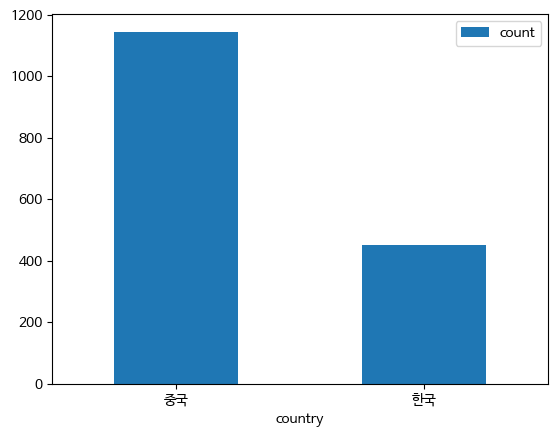

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

df_label_distribution.groupby('country')['count'].sum().reset_index().plot.bar(x='country', y='count', rot=0)
print(df_label_distribution.groupby('country')['count'].sum().reset_index())

## 1.2. 선종 분포

  ship_type  count
0      낚시어선    127
1      등광조망     96
2       범장망    436
3       안강망     51
4        연승     56
5        유망    196
6       저인망     81
7       채낚기     61
8        타망    417
9        통발     75


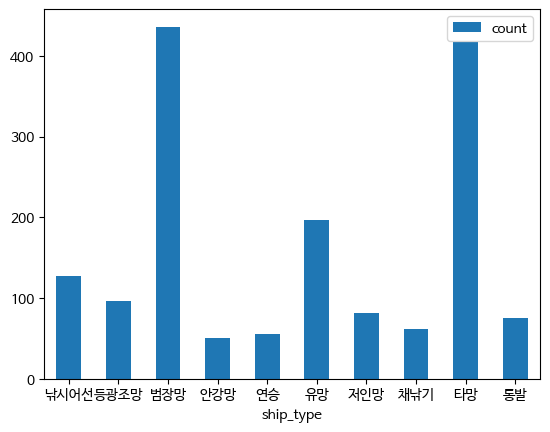

In [ ]:
df_label_distribution.groupby('ship_type')['count'].sum().reset_index().plot.bar(x='ship_type', y='count', rot=0)
print(df_label_distribution.groupby('ship_type')['count'].sum().reset_index())

## 1.3. 조업여부 분포

  status  count
0     이동    575
1     조업    343
2     표류    678


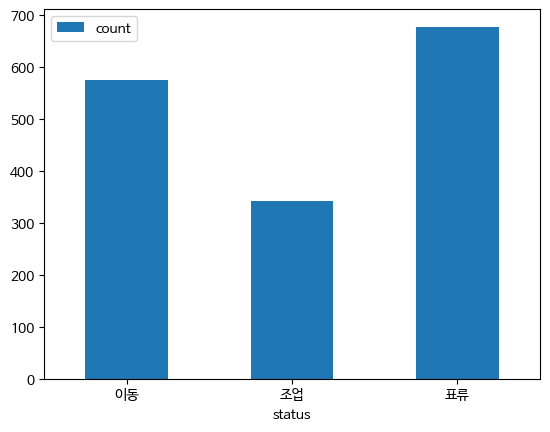

In [ ]:
df_label_distribution.groupby('status')['count'].sum().reset_index().plot.bar(x='status', y='count', rot=0)
print(df_label_distribution.groupby('status')['count'].sum().reset_index())

## 1.4. 선종 x 조업여부 분포

<Axes: xlabel='ship_type', ylabel='count'>

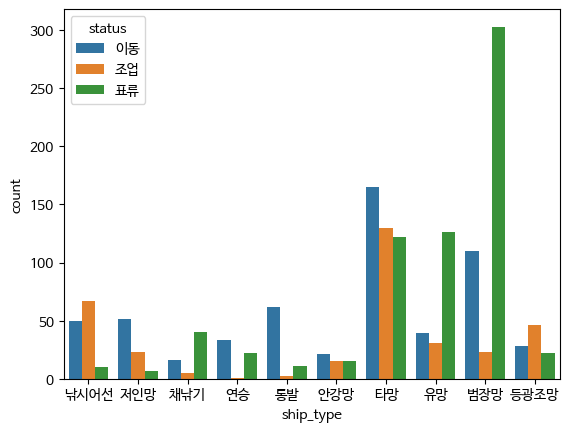

In [ ]:
import seaborn as sns

sns.barplot(x="ship_type", y="count", data=df_label_distribution, hue="status")

- 조업여부 (이동, 조업, 표류)은 생각한 것 보단 고루 분포하고 있음 (36%, 21.5%, 42.5%)
- 선종도 범장망(436), 타망(417), 유망(196)을 제외하면 50~100 인근의 고른 분포를 보임
- 따라서 하나의 모델로 2개의 head를 달아서 선종과 조업 여부를 한번에 예측하게 하는 것보다는, 처음부터 2개의 모델(선종 예측/조업여부 예측)을 예측하도록 하는 게 좋아보임